Population according to regions and buses

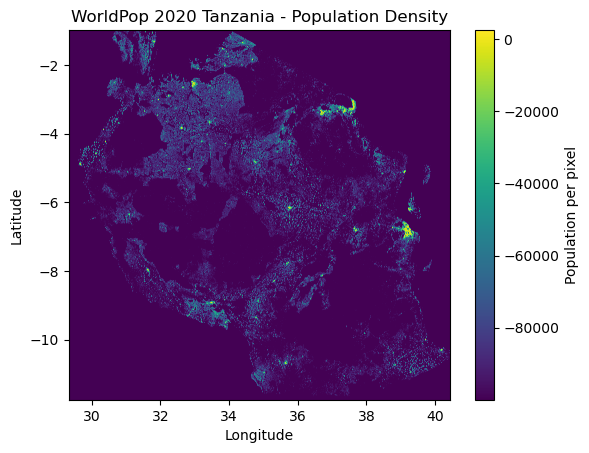

In [1]:
import rasterio
import matplotlib.pyplot as plt

tif_path = r"C:/Users/hie/pe_tan/pypsa-earth/data/WorldPop/tza_ppp_2020_UNadj_constrained.tif"

with rasterio.open(tif_path) as src:
    population = src.read(1)  # first (and only) band
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

plt.imshow(population, cmap='viridis', extent=extent)
plt.colorbar(label='Population per pixel')
plt.title('WorldPop 2020 Tanzania - Population Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Accurate population/region based on gadm shape.

Index(['GADM_ID', 'country', 'NAME_1', 'pop', 'gdp', 'geometry'], dtype='object')
Total population from GADM shapes: 59719273.40800086


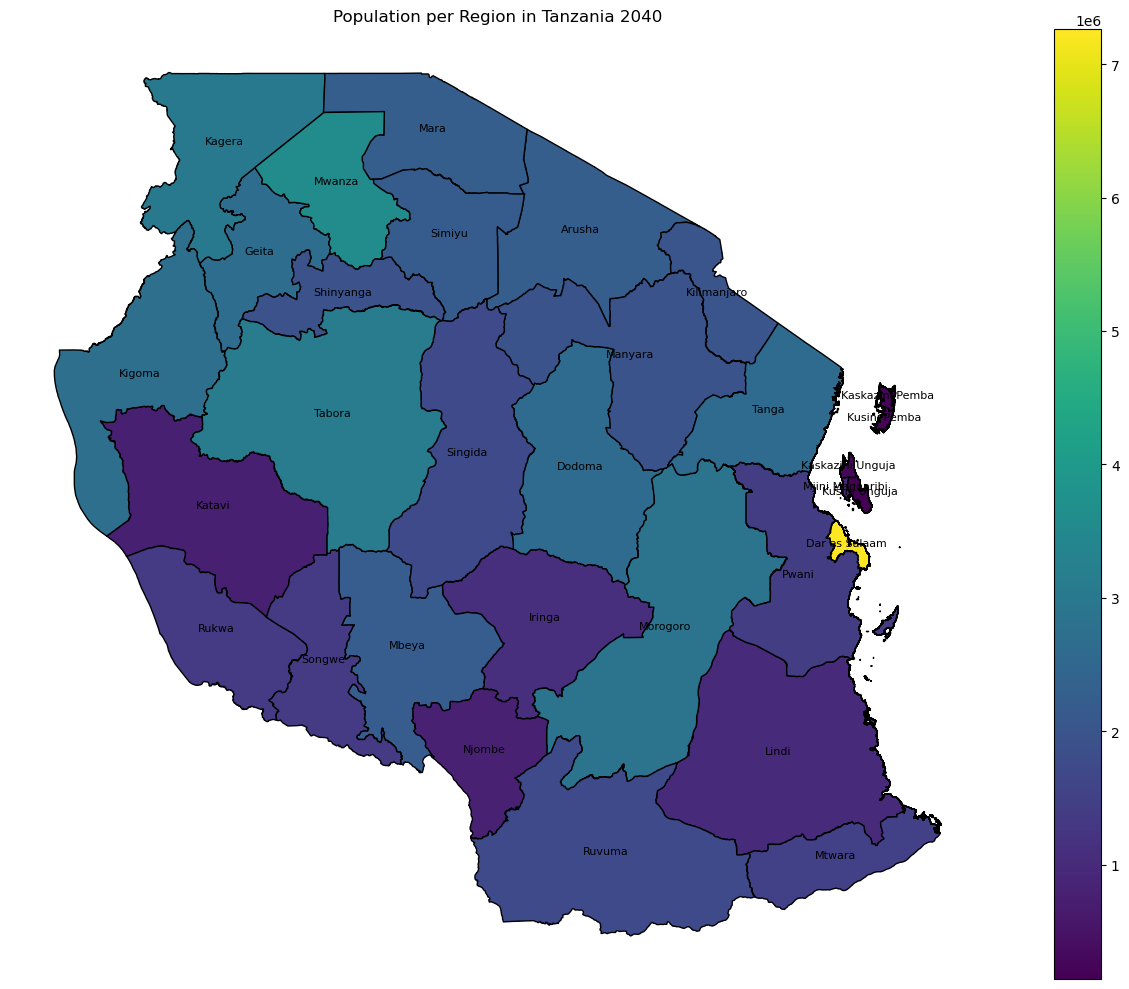

In [6]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


# Load GADM shapes with population and GDP and names
gadm_shapes = gpd.read_file("C:/Users/hie/pe_tan/pypsa-earth/resources/2040_base/shapes/gadm_shapes.geojson")
gadm_shapes = gadm_shapes.to_crs("EPSG:4326")

print(gadm_shapes.columns)
# Extract only the required fields
matched_df = gadm_shapes[["GADM_ID", "NAME_1", "pop"]].copy()
#matched_df.rename(columns={"pop": "Population", "NAME_1": "Region"}, inplace=True)

# Save to CSV
#matched_df.to_csv("C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/matched_population_by_region.csv", index=False)

# Define pop_by_region
pop_by_region = matched_df.groupby(["NAME_1", "pop"], as_index=False).sum()

# Calculate total population
total_population = pop_by_region["pop"].sum()
print(f"Total population from GADM shapes: {total_population}")

# Plot the population per region
fig, ax = plt.subplots(figsize=(14, 10))

# Merge population data with geometries
pop_plot = gadm_shapes.merge(pop_by_region, on=["NAME_1", "pop"])
pop_plot.plot(column="pop", cmap="viridis", legend=True, ax=ax, edgecolor="black")

# Add region names to the plot
for _, row in pop_by_region.iterrows():
    region_geom = gadm_shapes[gadm_shapes["NAME_1"] == row["NAME_1"]].geometry.values[0]
    centroid = region_geom.centroid
    ax.text(centroid.x, centroid.y, row["NAME_1"], fontsize=8, ha="center")

plt.title("Population per Region in Tanzania 2040")
plt.axis("off")
plt.tight_layout()
plt.show()

Index(['GADM_ID', 'country', 'NAME_1', 'pop', 'gdp', 'geometry'], dtype='object')
Total population from GADM shapes: 59719273.40800086


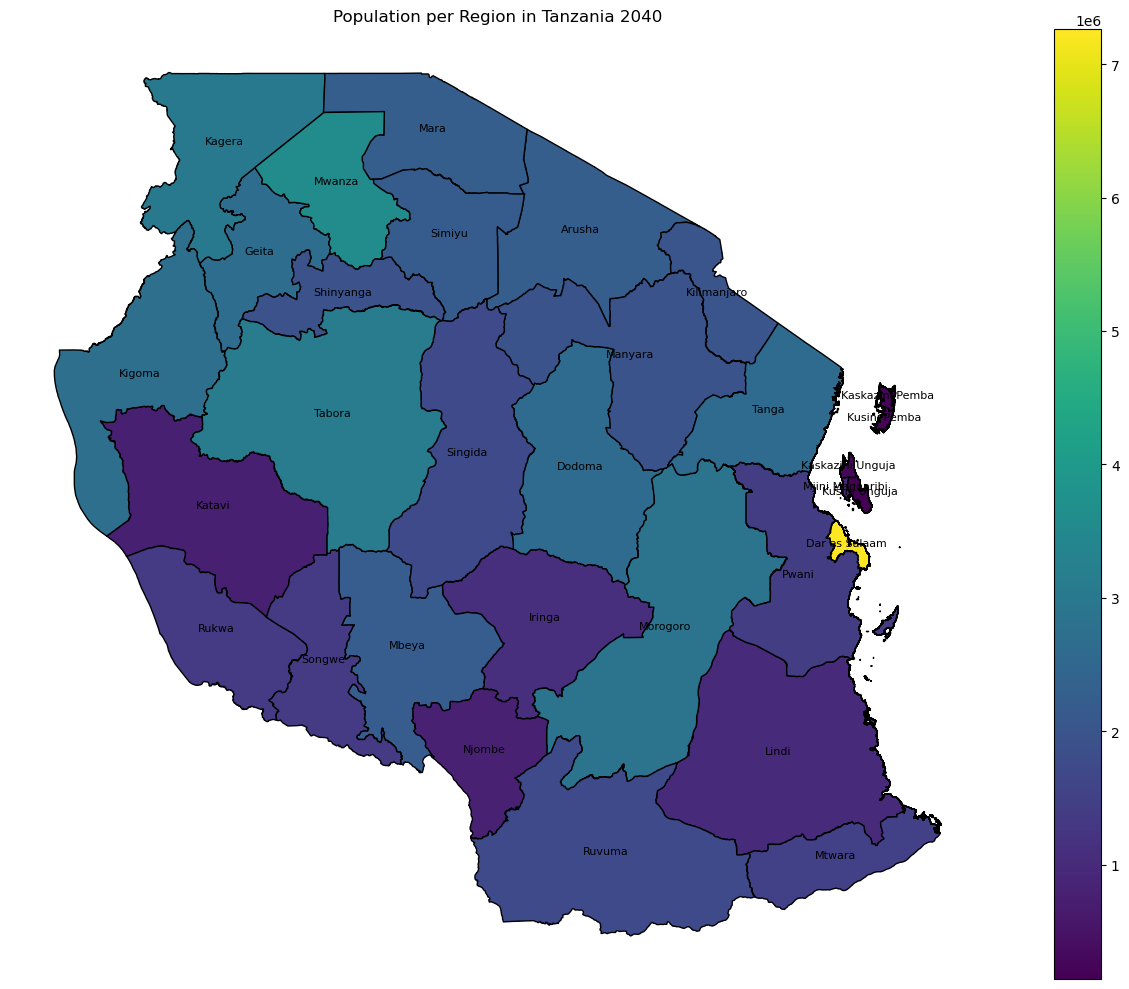

In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt


# Load GADM shapes with population and GDP and names
gadm_shapes = gpd.read_file("C:/Users/hie/pe_tan/pypsa-earth/resources/2030_base/shapes/gadm_shapes.geojson")
gadm_shapes = gadm_shapes.to_crs("EPSG:4326")

print(gadm_shapes.columns)
# Extract only the required fields
matched_df = gadm_shapes[["GADM_ID", "NAME_1", "pop"]].copy()
#matched_df.rename(columns={"pop": "Population", "NAME_1": "Region"}, inplace=True)

# Save to CSV
#matched_df.to_csv("C:/Users/hie/pe_tan/pypsa-earth/Script_analysis/matched_population_by_region.csv", index=False)

# Define pop_by_region
pop_by_region = matched_df.groupby(["NAME_1", "pop"], as_index=False).sum()

# Calculate total population
total_population = pop_by_region["pop"].sum()
print(f"Total population from GADM shapes: {total_population}")

# Plot the population per region
fig, ax = plt.subplots(figsize=(14, 10))

# Merge population data with geometries
pop_plot = gadm_shapes.merge(pop_by_region, on=["NAME_1", "pop"])
pop_plot.plot(column="pop", cmap="viridis", legend=True, ax=ax, edgecolor="black")

# Add region names to the plot
for _, row in pop_by_region.iterrows():
    region_geom = gadm_shapes[gadm_shapes["NAME_1"] == row["NAME_1"]].geometry.values[0]
    centroid = region_geom.centroid
    ax.text(centroid.x, centroid.y, row["NAME_1"], fontsize=8, ha="center")

plt.title("Population per Region in Tanzania 2040")
plt.axis("off")
plt.tight_layout()
plt.show()